In [116]:
import os
import numpy as np
import pickle
import math
from math import sqrt
from numpy import cos, sin

from pypcd import pypcd
from ceva import Ceva

# import rosbag
import rclpy

from builtin_interfaces.msg import Time
from geometry_msgs.msg import TransformStamped
from tf2_msgs.msg import TFMessage

import matplotlib.pyplot as plt

# from livox_ros_driver.msg import CustomPoint
# from livox_ros_driver.msg import CustomMsg

def toRosTime(time_double: float) -> Time:
    stamp = Time()
    stamp.sec = int(time_double)  # Whole seconds
    stamp.nanosec = int((time_double - stamp.sec) * 1e9)  # Convert fractional part to nanoseconds
    return stamp

import myutil.myutil as util
from myparproc.ParProc import ParProc
from myparproc.ProgressCheck import ProgressCheck

In [117]:
# # Lidar extrinsic
# T_B_L = [np.array([[ 1/sqrt(2),  0,  1/sqrt(2),  0],
#                    [ 0,          1,  0,          0],
#                    [-1/sqrt(2),  0,  1/sqrt(2),  0],
#                    [ 0,          0,  0,          1]]),
#          np.array([[-1,  0,  0, -0.5 ],
#                    [ 0, -1,  0,  0   ],
#                    [ 0,  0,  1, -0.25],
#                    [ 0,  0,  0,  1   ]]),
#         ]

# T_L0_L1 = util.tfmult(util.tfinv(T_B_L[0]), T_B_L[1])
# Rot01 = T_L0_L1[0:3, 0:3]
# Pos01 = T_L0_L1[0:3, 3]
# ypr01 = np.array(util.rotm2eul(Rot01))/math.pi*180
# print("xyz", Pos01)
# print("ypr", ypr01)


In [118]:
freq = 0.75
onesigma = 0.05

cloudpkl = f'cloud_ousterx2_w{int(freq*100)}_e{int(onesigma*100)}.pkl'
cloudbag = f'cloud_ousterx2_w{int(freq*100)}_e{int(onesigma*100)}.bag'

# Generate the trajectory
dt = 1e-4
tstart = 5
tmax = tstart + 30*(0.25/freq)


# Lidar extrinsic
T_B_L = [np.array([[ 1/sqrt(2),  0,  1/sqrt(2),  0],
                   [ 0,          1,  0,          0],
                   [-1/sqrt(2),  0,  1/sqrt(2),  0],
                   [ 0,          0,  0,          1]]),
         np.array([[-1,  0,  0, -0.5 ],
                   [ 0, -1,  0,  0   ],
                   [ 0,  0,  1, -0.25],
                   [ 0,  0,  0,  1   ]]),
        ]

lidar_type  = ['ouster', 'ouster']
lidar_line  = [16, 16]
time_offset = [0, 0.043]

# Number of lidars
Nl = len(T_B_L)

# The 6 planes
xb = 6
yb = 6
zb = 3
planes = [(np.array([1, 0, 0]).reshape((3, 1)), np.array([ xb, 0,  0 ]).reshape((3, 1))),
          (np.array([1, 0, 0]).reshape((3, 1)), np.array([-xb, 0,  0 ]).reshape((3, 1))),
          (np.array([0, 1, 0]).reshape((3, 1)), np.array([ 0,  yb, 0 ]).reshape((3, 1))),
          (np.array([0, 1, 0]).reshape((3, 1)), np.array([ 0, -yb, 0 ]).reshape((3, 1))),
          (np.array([0, 0, 1]).reshape((3, 1)), np.array([ 0,  0,  zb]).reshape((3, 1))),
          (np.array([0, 0, 1]).reshape((3, 1)), np.array([ 0,  0,  0 ]).reshape((3, 1)))]

# Radius
r = 2
# Frequency
w = freq
# Time span
t = np.arange(0, tmax, dt)

def xt(t):
    return 2*sin(w*t)
def vxt(t):
    return 2*w*cos(w*t)

def yt(t):
    return 2*sin(w*t)*cos(w*t)
def vyt(t):
    return 2*w*(cos(w*t)*cos(w*t) - sin(w*t)*sin(w*t))

# def xt(t):
#     return 2*sin(w*t)
# def vxt(t):
#     return 2*w*cos(w*t)

# def yt(t):
#     return 2*cos(w*t)*cos(w*t)
# def vyt(t):
#     return 2*w*(cos(w*t)*cos(w*t) - sin(w*t)*sin(w*t))

# x y z coordinates of the body
ts = []; psi = []; p_W_B = []; R_W_B = []; x = []; y = []; z = []; vx = []; vy = []; vz = []
for time in t:
    if time < tstart:
        tprime = time-tstart
        # Position
        x.append(0)
        y.append(0)
        z.append(0.75)
        # Velocity
        vx.append(0)
        vy.append(0)
        vz.append(0)
        # Orientation
        yaw = np.arctan2(vyt(0), vxt(0))
        psi.append(yaw)
        ts.append(tprime)
        rot = np.array([[cos(yaw), -sin(yaw), 0],
                        [sin(yaw),  cos(yaw), 0],
                        [       0,         0, 1]])
        R_W_B.append(rot)
    else:
        tprime = time-tstart
        # Position
        x.append(xt(tprime))
        y.append(yt(tprime))
        z.append(0.75)
        # Velocity
        vx.append(vxt(tprime))
        vy.append(vyt(tprime))
        vz.append(0)
        # Orientation
        yaw = np.arctan2(vy[-1], vx[-1])
        psi.append(yaw)
        ts.append(tprime)
        rot = np.array([[cos(yaw), -sin(yaw), 0],
                        [sin(yaw),  cos(yaw), 0],
                        [       0,         0, 1]])
        R_W_B.append(rot)

p_W_B = [np.array([x_, y_, z_]).reshape(3, 1) for x_, y_, z_ in zip(x, y, z)]

# Beam direction
e_inL = [[[] for line_idx in range(lidar_line[lidx])] for lidx in range(Nl)]

for lidx in range(Nl):
    if lidar_type[lidx] == 'avia':
        for line_idx in range(lidar_line[lidx]):
            er = cos(57*7*t)
            eu = er*cos(60.43*(t + 1.57*line_idx))
            ev = er*sin(60.43*(t + 1.57*line_idx))
            e_inL[lidx][line_idx] = [np.array([1, eu[idx], ev[idx]]).reshape(3, 1) for idx, stamp in enumerate(t)]
            e_inL[lidx][line_idx] = [e / np.linalg.norm(e) for e in e_inL[lidx][line_idx]]
            e_inL[lidx][line_idx] = np.array(e_inL[lidx][line_idx]).reshape(-1, 3)
    elif lidar_type[lidx] == 'mid360':
        for line_idx in range(lidar_line[lidx]):
            ex = cos(120.43*t) + 0.4*cos(150.7*(t + 0.025*line_idx))
            ey = sin(120.43*t) + 0.4*sin(150.7*(t + 0.025*line_idx))
            ez = 1
            e_inL[lidx][line_idx] = [np.array([ex[idx], ey[idx], ez]).reshape(3, 1) for idx, stamp in enumerate(t)]
            e_inL[lidx][line_idx] = [e / np.linalg.norm(e) for e in e_inL[lidx][line_idx]]
            e_inL[lidx][line_idx] = np.array(e_inL[lidx][line_idx]).reshape(-1, 3)
    elif lidar_type[lidx] == 'ouster':
        for line_idx in range(lidar_line[lidx]):
            eyaw = (t*20*math.pi)
            ethe = (-22.5 + 90.0/lidar_line[lidx]*line_idx)/180*math.pi
            ex = cos(eyaw)*cos(ethe)
            ey = sin(eyaw)*cos(ethe)
            ez = sin(ethe)
            # print(ez, line_idx,45.0/lidar_line[lidx], (-22.5 + 45.0/lidar_line[lidx]*line_idx))
            e_inL[lidx][line_idx] = [np.array([ex[idx], ey[idx], ez]).reshape(3, 1) for idx, stamp in enumerate(t)]
            e_inL[lidx][line_idx] = [e / np.linalg.norm(e) for e in e_inL[lidx][line_idx]]
            e_inL[lidx][line_idx] = np.array(e_inL[lidx][line_idx]).reshape(-1, 3)


2999


Text(0.5, 0, 'm')

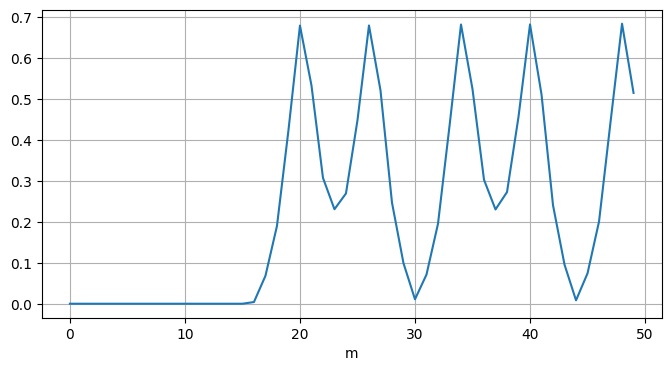

In [121]:
def smooth_angle(ca, pa):
    ca_a = ca + 2*np.pi
    ca_b = ca - 2*np.pi
    ca_c = ca     
    data = [ca_a, ca_b, ca_c]     
    absdata = [abs(ca_a - pa), abs(ca_b - pa), abs(ca_c - pa)]
    minidx = absdata.index(min(absdata))
    return data[minidx]

figpos = (8, 4)
fig, ax = plt.subplots(nrows=1, ncols= 1, figsize=figpos)    

tss  = [ts[0] ]
psi_ = [psi[0]]
knotlength = 0.3
span = int(knotlength/dt)
print(span)
for idx, yaw in enumerate(psi):
    if idx == 0:
        continue
    if idx % span == 0:
        psi_.append(smooth_angle(yaw, psi_[-1]))
        tss.append(ts[idx])

dpsi_ = [ abs(psi_[idx] - psi_[idx-1]) for idx, _ in enumerate(psi_) if idx > 0]
ax.plot(dpsi_)
# ax.set_ylim([-0.2, 0.2])
ax.grid('on')
ax.set_xlabel('m')

In [ ]:
# Return the point on the wall that a beam hits
def findHitpoint(p, e, std_dev=0):
    # Check if the ray hits any of the planes
    for n, m in planes:
        nm_ = np.squeeze(n.T@m)
        np_ = np.squeeze(n.T@p)
        ne_ = np.squeeze(n.T@e)
        eta = np.random.normal(0, std_dev, 1)
        if ne_ == 0:
            continue
        else:
            s = (nm_ - np_)/ne_
            h = p + (s + eta)*e
            if s > 0 and -xb <= h[0] <= xb and -yb <= h[1] <= yb and 0 <= h[2] <= zb:
                return s, h, ne_.item()
    return 0, p, 0

In [ ]:
# # Visualize the trajectory

# figpos = [18, 6]
# fig, ax = plt.subplots(nrows=1, ncols= 1 + Nl, figsize=figpos)

# # ax[0].clear()
# # ax[0] = fig.add_subplot(111, projection='3d')
# ax[0].plot(x, y)
# ax[0].set_xlabel('x [m]')
# ax[0].set_ylabel('y [m]')
# # ax[0].set_zlabel('z [m]')

# ax[0].grid('on')

# flower = [[[] for line_idx in range(lidar_line[lidx])] for lidx in range(Nl)]
# for lidx in range(0, Nl):
#     for line_idx in range(lidar_line[lidx]):
#         flower[lidx][line_idx].append(ax[lidx+1].plot(0, 0, '2r'))
#         flower[lidx][line_idx].append(ax[lidx+1].plot(0, 0, 'b'))
#     ax[lidx+1].set_aspect('equal')
#     ax[lidx+1].set_xlim([-1.2, 1.2])
#     ax[lidx+1].set_ylim([-1.2, 1.2])

# # Plot the velcity at t = 69
# arrow = None
# idx_prev = 0
# idx_curr = 0
# for idx_curr, time in enumerate(t):
    
#     # idx = np.where(t==time)[0][0]
#     if (idx_curr - idx_prev)*dt < 0.1:
#         continue

#     if time > 6.0:
#         break

#     px_ =  p_W_B[idx_curr][0]
#     py_ =  p_W_B[idx_curr][1]

#     # if arrow is not None:
#     #     arrow.remove()
#     # arrow = ax[0].arrow(px_, py_, vx_, vy_, width=0.01, head_width=0.05, head_length=0.1, fc='blue', ec='blue')

#     # if vxline is not None or vyline is not None:
#     #     vxline.remove()
#     #     vyline.remove()
#     # vxline, = ax[1].plot(t[:idx_curr], vx[:idx_curr], 'r')
#     # vyline, = ax[1].plot(t[:idx_curr], vy[:idx_curr], 'b')

#     for lidx in range(Nl):
#         for line_idx in range(lidar_line[lidx]):
#             flower[lidx][line_idx][0][0].set_data(e_inL[lidx][line_idx][idx_prev:idx_curr, 1], e_inL[lidx][line_idx][idx_prev:idx_curr, 2])
#             # flower[lidx][line_idx][1][0].set_data(e_inL[lidx][line_idx][0:idx_curr,        1], e_inL[lidx][line_idx][0:idx_curr,        2])

#     idx_prev = idx_curr
    
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
    

In [ ]:
# Generate the point for each lidar over the trajectory

clouds = []
for n in range(Nl):
    clouds.append([])

def makeCloudData(lidx, proc_idx=None, output_queue=None):
    
    # Create the progress checker
    pck = ProgressCheck(len(t))
    
    # List to store the points
    cloud = []
    
    # Get the extrinsics
    R_B_L, t_B_L = T_B_L[lidx][:3, :3], T_B_L[lidx][:3, 3].reshape(3, 1)

    for idx, stamp in enumerate(t):

        # if 10 < stamp < 20 and lidx == 1:
        #     t_B_L_dyn = t_B_L + np.array([0, 0, -0.1]).reshape((3, 1))
        # else:
        #     t_B_L_dyn = t_B_L
        
        t_B_L_dyn = t_B_L
        
        # Find the lidar rotation
        R_W_L = R_W_B[idx] @ R_B_L
        q_W_L = util.rotm2quat(R_W_L)

        # Find the lidar position
        p_W_L = p_W_B[idx] + R_W_B[idx] @ t_B_L_dyn

        h_inL = [[] for line_idx in range(lidar_line[lidx])]
        cosne = [[] for line_idx in range(lidar_line[lidx])]

        for line_idx in range(lidar_line[lidx]):
            # Find beam direction
            # e_inL = np.array([1, eu[idx], ev[idx]]).reshape(3, 1)
            # e_inL[lidx] = e_inL[lidx] / np.linalg.norm(e_inL)
            e_inW = R_W_L@e_inL[lidx][line_idx][idx].reshape((3, 1))

            # Find the hit point
            s, h_inW, cosne[line_idx] = findHitpoint(p_W_L, e_inW, onesigma)

            # Transform the point to lidar frame
            h_inL[line_idx] = R_W_L.T@(h_inW - p_W_L)

        # Extract the elements
        # px, py, pz = h_inL[0].item(), h_inL[1].item(), h_inL[2].item()
        # qx, qy, qz, qw = q_W_L[1].item(), q_W_L[2].item(), q_W_L[3].item(), q_W_L[0].item()

        # Store the point
        cloud.append([stamp, h_inL, p_W_L, R_W_L, cosne])

        # Update the progress
        pck.updateProgress(f'Lidar {lidx} Generation: ')

    if proc_idx is not None and output_queue is not None and len(output_queue) > proc_idx:
        output_queue[proc_idx] = cloud

# Add the jobs
pp = ParProc(Nl)
for lidx in range(Nl):
    pp.addprocwithoutput(makeCloudData, lidx, lidx)
    # makeCloudData(lidx, lidx, clouds)
pp.join()

# Extract the output
clouds = list(pp.output_queue)


In [ ]:
# # Dump the data
# with open(cloudpkl, 'wb') as f:
#     pickle.dump(clouds, f)


In [ ]:
# # Load the data
# with open(cloudpkl, 'rb') as file:
#     clouds = pickle.load(file)


In [ ]:
# Export the data
outputdir = cloudbag
outputdir = outputdir.replace('.bag', '') + '/clouds/'
for lidx, _ in enumerate(lidar_type):
    os.makedirs(outputdir + f'/__lidar_{lidx}__points', exist_ok=True)

# # Create the rosbag
# bag = rosbag.Bag(cloudbag, 'w')

pose_gtr = [[] for lidx, _ in enumerate(lidar_type)]

# Loop through the points and write the pointcloud
for lidx, points in enumerate(clouds):
    
    Npoints = len(points)
    idx_offset = int(time_offset[lidx]/dt)
    
    # bidx means "beginning index"
    for bidx in range(idx_offset, Npoints, int(0.1/dt)):
        
        if (bidx + int(0.1/dt) > Npoints):
            continue

        scan = []
        t0 = clouds[lidx][bidx][0]

        # if t0 > 20:
        #     break
        
        for idx in range(bidx, bidx + int(0.1/dt), int(0.1/dt/5)):
            
            if idx > bidx + bidx + int(0.1/dt) - int(0.1/dt/5):
                continue
            
            t = clouds[lidx][idx][0]
            p_W_L = clouds[lidx][idx][2]
            R_W_L = clouds[lidx][idx][3]
            q_W_L = util.rotm2quat(R_W_L)
            pose_gtr[lidx].append((p_W_L[0], p_W_L[1], p_W_L[2], t, t,
                                   q_W_L[1], q_W_L[2], q_W_L[3], q_W_L[0]))
        
        # Extract the pose at regular interval
        for idx in range(bidx, bidx + int(0.1/dt), int(0.1/dt/5)):
            
            if idx > bidx + bidx + int(0.1/dt) - int(0.1/dt/5):
                continue
            
            t = clouds[lidx][idx][0]
            p_W_L = clouds[lidx][idx][2]
            R_W_L = clouds[lidx][idx][3]
            q_W_L = util.rotm2quat(R_W_L)
            pose_gtr[lidx].append((p_W_L[0], p_W_L[1], p_W_L[2], t, t,
                                   q_W_L[1], q_W_L[2], q_W_L[3], q_W_L[0]))

        for idx in range(bidx, bidx + int(0.1/dt)):
            for line_idx in range(lidar_line[lidx]):
                pt = int((clouds[lidx][idx][0] - t0)*1e9)
                px = clouds[lidx][idx][1][line_idx][0]
                py = clouds[lidx][idx][1][line_idx][1]
                pz = clouds[lidx][idx][1][line_idx][2]
                pi = abs(1.0 - clouds[lidx][idx][-1][line_idx])*1000
                scan.append((px, py, pz, pi, pt, line_idx))

        p_W_L = clouds[lidx][bidx][2]
        R_W_L = clouds[lidx][bidx][3]
        q_W_L = util.rotm2quat(R_W_L)
        
        stamp = toRosTime(t0)
        
        # Convert scan to pointcloud msg
        scan = np.array(scan, dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('intensity', '<f4'), ('t', '<u4'), ('ring', np.uint8)])
        # scan_msg = pypcd.PointCloud.from_array(scan).to_msg()
        # scan_msg.header.stamp = rclpy.Time(t0)
        # scan_msg.header.frame_id = f'lidar_{lidx}'

        # # Convert scan to livox msg
        # livox_msg = CustomMsg()
        # livox_msg.header = scan_msg.header
        # livox_msg.timebase = int(t0*1e9)
        # livox_msg.point_num = len(scan)
        # livox_msg.points =[] 
        # for point in scan:
        #     lvpoint = CustomPoint()
        #     lvpoint.offset_time = point['t'].item()
        #     lvpoint.x = point['x'].item()
        #     lvpoint.y = point['y'].item()
        #     lvpoint.z = point['z'].item()
        #     lvpoint.reflectivity = np.uint8(point['intensity'].item()/1000.0*255)
        #     lvpoint.tag = 0
        #     lvpoint.line = point['ring']
        #     livox_msg.points.append(lvpoint)
        
        # print(f"Created scan with {livox_msg.point_num} points")
        
        pcd_name = outputdir + f'/__lidar_{lidx}__points/{stamp.sec:04d}.{stamp.nanosec:09d}.pcd'
        pypcd.PointCloud.from_array(scan).save_pcd(pcd_name, compression='binary')

        # # Create a tf message
        # transform_msg_config = TFMessage()
        # transform_msg = TransformStamped()
        # transform_msg.header.stamp = rclpy.Time(t0)
        # transform_msg.header.frame_id = 'world'
        # transform_msg.header.seq = int(bidx % 1e4)
        # transform_msg.child_frame_id = f'lidar_{lidx}'
        # transform_msg.transform.translation.x = p_W_L[0].item()
        # transform_msg.transform.translation.y = p_W_L[1].item()
        # transform_msg.transform.translation.z = p_W_L[2].item()
        # transform_msg.transform.rotation.x = q_W_L[1].item()
        # transform_msg.transform.rotation.y = q_W_L[2].item()
        # transform_msg.transform.rotation.z = q_W_L[3].item()
        # transform_msg.transform.rotation.w = q_W_L[0].item()
        # transform_msg_config.transforms.append(transform_msg)

        # pose_gtr[lidx].append((transform_msg.transform.translation.x,
        #                        transform_msg.transform.translation.y,
        #                        transform_msg.transform.translation.z,
        #                        t0, t0,
        #                        transform_msg.transform.rotation.x,
        #                        transform_msg.transform.rotation.y,
        #                        transform_msg.transform.rotation.z,
        #                        transform_msg.transform.rotation.w))
        
        # bag.write(f'/lidar_{lidx}/points', scan_msg, rospy.Time(t0))
        # bag.write(f'/lidar_{lidx}/points_livox', livox_msg, rospy.Time(t0))
        # bag.write(f'/tf', transform_msg_config, rospy.Time(t0))

# # Close the bag
# bag.close()

# Save the ground truth
os.makedirs(outputdir + '/../gtr/', exist_ok=True)
for lidx, _ in enumerate(lidar_type):
    pypcd.PointCloud.from_array(np.array(pose_gtr[lidx],
        dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('intensity', '<f4'), ('t', '<f8'),
               ('qx', '<f4'), ('qy', '<f4'), ('qz', '<f4'), ('qw', '<f4')])
        ).save_pcd(outputdir + f'/../gtr/lidar_{lidx}_gtr.pcd', compression='ascii', precision=9)


In [ ]:
# !rosbag play $cloudbag & rviz -d /home/tmn/ros_ws/dev_ws/src/gptr/scripts/gptr.rviz

In [ ]:
# import math

# # Generate the priormap

# da = 0.5

# psi_ = list(np.arange(0, 360, da))
# theta_ = list(np.arange(-60, 60, da))

# p0 = np.array([0, 0, 1.5]).reshape((3, 1))
# priormap = []

# pck = ProgressCheck(len(psi_))
# for yaw_deg in psi_:
#     for pitch_deg in theta_:
        
#         # Angles in radiance
#         yaw_rad = yaw_deg*math.pi/180
#         pitch_rad = pitch_deg*math.pi/180

#         # Beam bearing
#         ex = cos(yaw_rad)*cos(pitch_rad)
#         ey = sin(yaw_rad)*cos(pitch_rad)
#         ez = sin(pitch_rad)
#         e  = np.array([ex, ey, ez]).reshape((3, 1))

#         # Find the hit point
#         s, h, cosne = findHitpoint(p0, e, 0.001)

#         # Extract the x y z intensity
#         x = h[0].item()
#         y = h[1].item()
#         z = h[2].item()
#         intensity = abs(cosne)*1000

#         # Save the point
#         priormap.append((x, y, z, intensity))
    
#     # Update the progress
#     pck.updateProgress('Generating priormap: ')

# # Convert to array
# priormap = np.array(priormap, dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('intensity', '<f4')])

# # Save the pointcloud
# pypcd.save_point_cloud_bin(pypcd.PointCloud.from_array(priormap), 'priormap.pcd')


In [ ]:
from IPython import get_ipython
get_ipython().magic('reset -f')